Standard DMDc Results:
A_tilde:
 [[ 0.99720074  0.10712473]
 [-0.0013859   0.99018749]]
B_tilde:
 [[-0.28879265]
 [-0.01259348]]
Eigenvalues:
 [0.99369412+0.01166911j 0.99369412-0.01166911j]
DMD Modes:
 [[-0.96268794 -0.96268794]
 [-0.2217571  -0.2217571 ]]
RMSE: [129.27695596  23.58034892]

Improved DMDc Results:
A_tilde:
 [[ 0.98739764 -0.00164519]
 [ 0.10686544  0.9999906 ]]
B_tilde:
 [[-0.0049534 ]
 [-0.28902466]]
Eigenvalues:
 [0.99369412+0.01166911j 0.99369412-0.01166911j]
DMD Modes:
 [[0.96277584 0.96277584]
 [0.22145924 0.22145924]]
RMSE: [ 94.99247364 137.09216433]


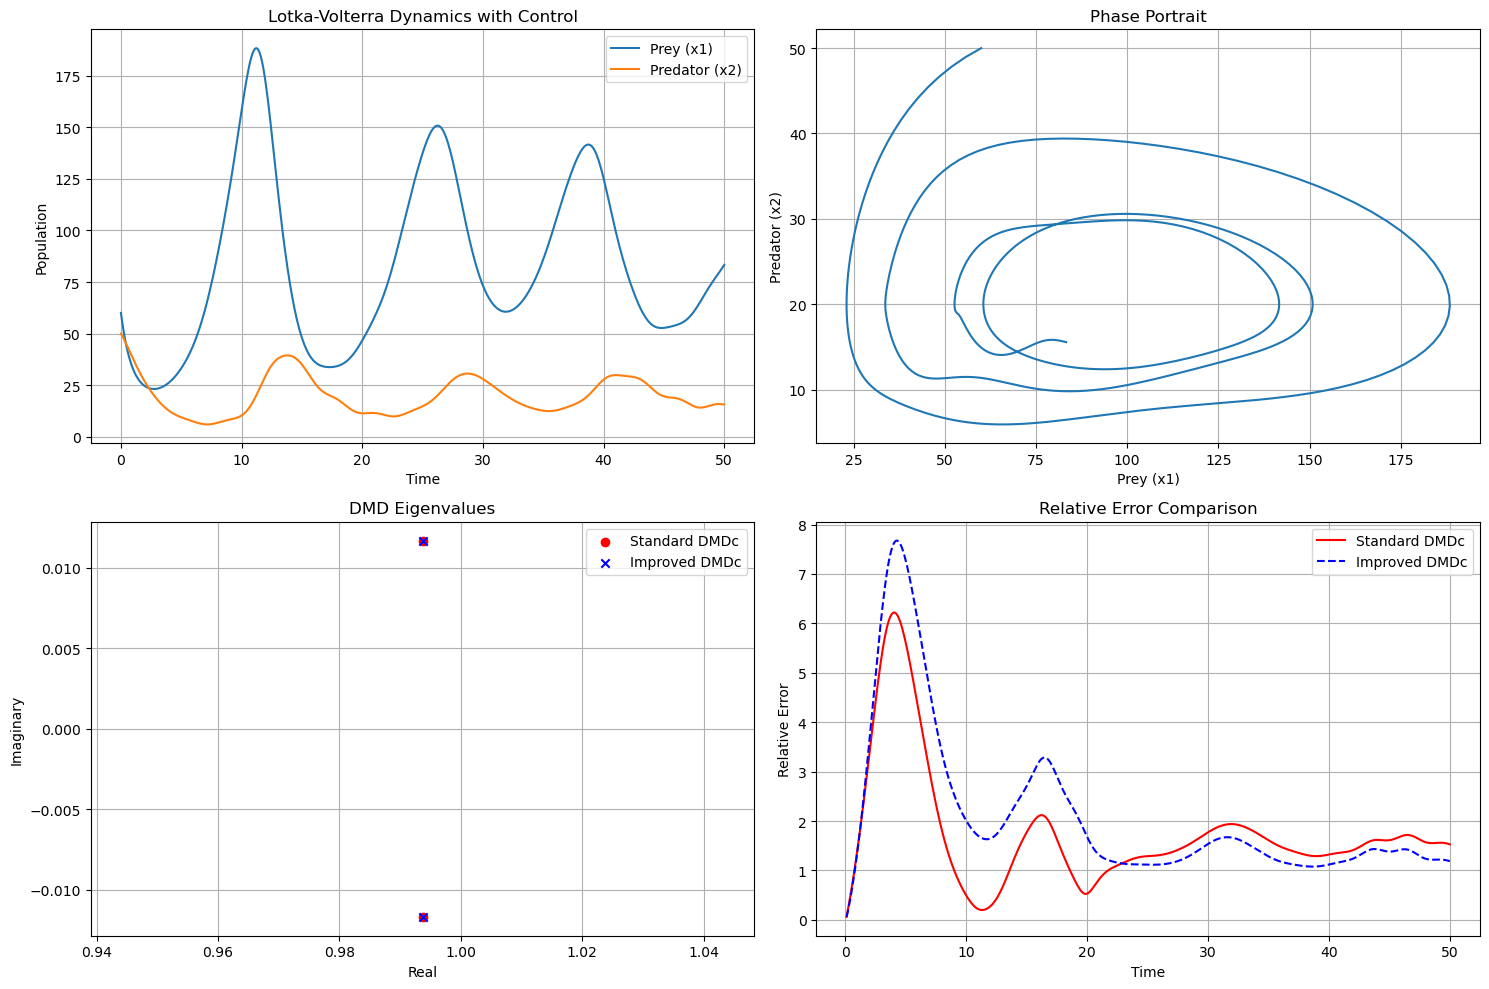

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.linalg import svd, eig

# Parameters for Lotka-Volterra system
alpha = 0.5
beta = 0.025
gamma = 0.5
delta = 0.005

# Control input function
def control_input(t):
    return (2 * np.sin(t) * np.sin(t/10))**2

# Lotka-Volterra system with control
def lotka_volterra(x, t):
    x1, x2 = x
    dx1dt = alpha * x1 - beta * x1 * x2
    dx2dt = -gamma * x2 + delta * x1 * x2 + control_input(t)
    return [dx1dt, dx2dt]

# Simulation parameters
t0 = 0
tf = 50
dt = 0.1
#501 points
t = np.arange(t0, tf + dt, dt)
#Initial conditions
x0 = [60, 50]

# Simulate the system
sol = odeint(lotka_volterra, x0, t)
x1 = sol[:, 0]
x2 = sol[:, 1]

# Create snapshot matrices
m = len(t) - 1
# x0 to xm-1 (2 × 500)
X = sol[:-1].T
# x1 to xm (2 × 500)
Y = sol[1:].T
# 1 × 500
Gamma = np.array([control_input(t[i]) for i in range(m)]).reshape(1, -1)

# Standard DMDc (Algorithm 1)
def standard_dmdc(X, Y, Gamma, p=3, r=2):
    # Step 1: Construct Omega
    # (2+1) × 500
    Omega = np.vstack([X, Gamma])

    # Step 2: Truncated SVD of Omega
    U, S, Vh = svd(Omega, full_matrices=False)
    U_tilde = U[:, :p]
    Sigma_tilde = np.diag(S[:p])
    V_tilde = Vh[:p, :].T

    # Step 3: Truncated SVD of Y
    U_hat, S_hat, Vh_hat = svd(Y, full_matrices=False)
    U_hat_tilde = U_hat[:, :r]
    Sigma_hat_tilde = np.diag(S_hat[:r])
    V_hat_tilde = Vh_hat[:r, :].T

    # Step 4: Split U_tilde
    U1 = U_tilde[:X.shape[0], :]
    U2 = U_tilde[X.shape[0]:, :]

    # Compute reduced A and B
    A_tilde = U_hat_tilde.T @ Y @ V_tilde @ np.linalg.inv(Sigma_tilde) @ U1.T @ U_hat_tilde
    B_tilde = U_hat_tilde.T @ Y @ V_tilde @ np.linalg.inv(Sigma_tilde) @ U2.T

    # Step 5: Eigenvalue decomposition
    lambdas, W = eig(A_tilde)

    # Step 6: DMD modes
    Phi = Y @ V_tilde @ np.linalg.inv(Sigma_tilde) @ U1.T @ U_hat_tilde @ W

    return A_tilde, B_tilde, lambdas, Phi

def improved_dmdc(X, Y, Gamma, p=3, r=2):
    Omega = np.vstack([X, Gamma])
    U, S, Vh = svd(Omega, full_matrices=False)
    U_tilde = U[:, :p]
    Sigma_tilde = np.diag(S[:p])
    V_tilde = Vh[:p, :].T


    U1 = U_tilde[:X.shape[0], :]
    U2 = U_tilde[X.shape[0]:, :]
    Omega1 = V_tilde @ np.linalg.inv(Sigma_tilde) @ U1.T
    Omega2 = V_tilde @ np.linalg.inv(Sigma_tilde) @ U2.T

    H = np.linalg.inv(Sigma_tilde) @ U1.T
    U_h, S_h, Vh_h = svd(H, full_matrices=False)
    U_h = U_h[:, :r]
    Sigma_h = np.diag(S_h[:r])
    V_h = Vh_h[:r, :].T


    U_bar = V_tilde @ U_h
    Sigma_bar = Sigma_h
    V_bar = V_h

    temp = Y @ U_bar @ Sigma_bar
    A_tilde = V_bar.T @ temp
    B_tilde = V_bar.T @ Y @ Omega2



    lambdas, W = eig(A_tilde)
    Phi = Y @ U_bar @ Sigma_bar @ W

    return A_tilde, B_tilde, lambdas, Phi

# Apply both algorithms
A_std, B_std, lambdas_std, Phi_std = standard_dmdc(X, Y, Gamma)
A_imp, B_imp, lambdas_imp, Phi_imp = improved_dmdc(X, Y, Gamma)

# Compute predictions for RMSE calculation
def predict_dmdc(X, Gamma, A, B, steps):
    X_pred = np.zeros((X.shape[0], steps))
    X_pred[:, 0] = X[:, 0]
    for i in range(1, steps):
        X_pred[:, i] = A @ X_pred[:, i-1] + B @ Gamma[:, i-1]
    return X_pred

steps = X.shape[1]
X_pred_std = predict_dmdc(X, Gamma, A_std, B_std, steps)
X_pred_imp = predict_dmdc(X, Gamma, A_imp, B_imp, steps)

# Compute RMSE
def rmse(actual, predicted):
    return np.sqrt(np.mean((actual - predicted)**2, axis=1))

rmse_std = rmse(Y, X_pred_std)
rmse_imp = rmse(Y, X_pred_imp)

# Compute relative error
def relative_error(actual, predicted):
    return np.linalg.norm(actual - predicted, axis=0) / np.linalg.norm(actual, axis=0)

re_std = relative_error(Y, X_pred_std)
re_imp = relative_error(Y, X_pred_imp)

# Print results
print("Standard DMDc Results:")
print("A_tilde:\n", np.real(A_std))
print("B_tilde:\n", np.real(B_std))
print("Eigenvalues:\n", lambdas_std)
print("DMD Modes:\n", np.real(Phi_std))
print("RMSE:", rmse_std)

print("\nImproved DMDc Results:")
print("A_tilde:\n", np.real(A_imp))
print("B_tilde:\n", np.real(B_imp))
print("Eigenvalues:\n", lambdas_imp)
print("DMD Modes:\n", np.real(Phi_imp))
print("RMSE:", rmse_imp)

# Plot the results
plt.figure(figsize=(15, 10))

# Plot system dynamics
plt.subplot(2, 2, 1)
plt.plot(t, x1, label='Prey (x1)')
plt.plot(t, x2, label='Predator (x2)')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Lotka-Volterra Dynamics with Control')
plt.legend()
plt.grid(True)

# Plot phase portrait
plt.subplot(2, 2, 2)
plt.plot(x1, x2)
plt.xlabel('Prey (x1)')
plt.ylabel('Predator (x2)')
plt.title('Phase Portrait')
plt.grid(True)

# Plot DMD eigenvalues
plt.subplot(2, 2, 3)
plt.scatter(np.real(lambdas_std), np.imag(lambdas_std), c='r', label='Standard DMDc')
plt.scatter(np.real(lambdas_imp), np.imag(lambdas_imp), c='b', marker='x', label='Improved DMDc')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('DMD Eigenvalues')
plt.legend()
plt.grid(True)

# Plot relative errors
plt.subplot(2, 2, 4)
plt.plot(t[1:], re_std, 'r', label='Standard DMDc')
plt.plot(t[1:], re_imp, 'b--', label='Improved DMDc')
plt.xlabel('Time')
plt.ylabel('Relative Error')
plt.title('Relative Error Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()